In [1]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
transoforms = tv.transforms.Compose([tv.transforms.Grayscale(3), tv.transforms.Resize((224, 224)), tv.transforms.ToTensor()])
Batch_size = 512
Lr = 0.001
loss = torch.nn.CrossEntropyLoss(reduction='sum')

Data_train = tv.datasets.EMNIST('.', split='balanced', train=True, download=True, transform=transoforms)
Data_test = tv.datasets.EMNIST('.', split='balanced', train=False, download=True, transform=transoforms)

Train = torch.utils.data.DataLoader(Data_train, batch_size=Batch_size, shuffle=True)
Test = torch.utils.data.DataLoader(Data_test, batch_size=Batch_size)

In [4]:
Data_train

Dataset EMNIST
    Number of datapoints: 112800
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=3)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [5]:
Data_train[0][0].shape

torch.Size([3, 224, 224])

In [6]:
print(*Data_test.classes)

0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z a b d e f g h n q r t


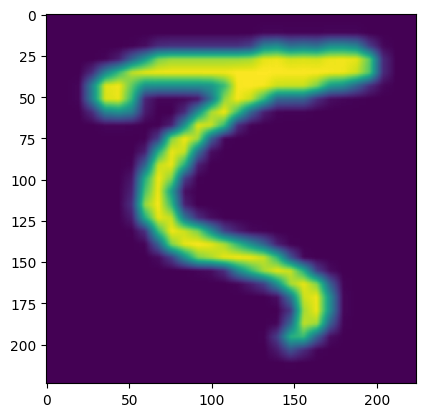

In [7]:
plt.imshow(Data_train[2][0][0].squeeze())

In [8]:
def class_analysis(dataset):
    res = dict()
    for X, Y in dataset:
        if Y in res:
            res[Y] += 1            
        else:
            res[Y] = 1
    print(f'Количество классов в датасете {len(res)}')
    plt.bar(res.keys(), res.values())
    plt.title('Распределение классов в датасете')
    plt.show()

Количество классов в датасете 47


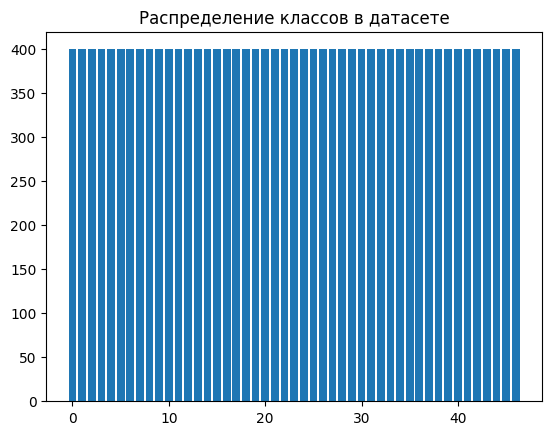

In [9]:
class_analysis(Data_test)

Количество классов в датасете 47


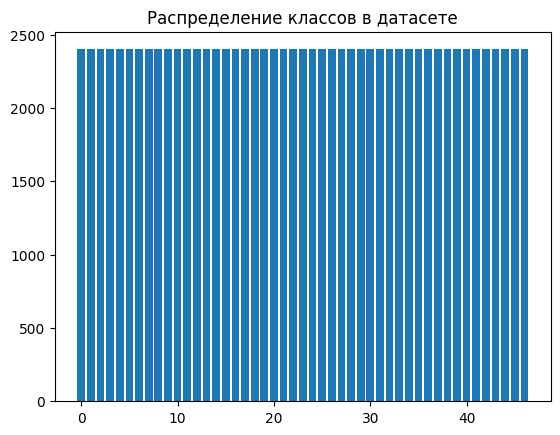

In [10]:
class_analysis(Data_train)

In [11]:
def train(model, train_iter, test_iter, trainer, model_name, epoch_num=10, plot=True, verbose=False):

    hist_train = np.empty(epoch_num)
    hist_test = np.empty(epoch_num)
    acc_train = np.empty(epoch_num)
    acc_test = np.empty(epoch_num)
        
    model.to(device)  
        
    for epoch in range(epoch_num):
        hist_train_epoch = 0
        acc_train_epoch = 0
        n = 0
        model.train()
        for i, (X, Y) in enumerate(train_iter):
            X, Y = X.to(device), Y.to(device)
            trainer.zero_grad()
            if model_name == 'Inception v3':
                y_hat, __ = model(X)
            else:
                y_hat = model(X)
            l = loss(y_hat, Y)
            l.backward()
            trainer.step()
            hist_train_epoch += l.item()
            acc_train_epoch += (y_hat.argmax(axis=1) == Y).sum().item()
            n += Y.shape[0]

            if verbose:
                print(f'Done {i} of {len(train_iter)} in train epoch {epoch}', end='\r')
                
        hist_train[epoch] = hist_train_epoch/n
        acc_train[epoch] = acc_train_epoch/n*100
        
        model.eval()
        hist_test_epoch = 0
        acc_test_epoch = 0
        n = 0
        for i, (X, Y) in enumerate(test_iter):
            X, Y = X.to(device), Y.to(device)
            if model_name == 'Inception v3':
                y_hat, __ = model(X)
            else:
                y_hat = model(X)
            l = loss(y_hat, Y)
            hist_test_epoch += l.item()
            acc_test_epoch += (y_hat.argmax(axis=1) == Y).sum().item()
            n += Y.shape[0]
            
            if verbose:
                print(f'Done {i} of {len(train_iter)} in test epoch {epoch}', end='\r')
                
        hist_test[epoch] = hist_test_epoch/n
        acc_test[epoch] = acc_test_epoch/n*100
        
        if verbose:
            print(f'Выполнена эпоха - {epoch}  Результаты: \n Loss -- {hist_train[epoch]}/{hist_test[epoch]}, Acc -- {acc_train[epoch]}/{acc_test[epoch]}')
            
    if plot:
        plt.subplot(1, 2, 1)
        plt.plot(hist_test, label='Loss test')
        plt.plot(hist_train, label='Loss train')
        plt.legend()
        plt.title(f'Loss {model_name}')
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.plot(acc_test, label='Acc test, %')
        plt.plot(acc_train, label='Acc train, %')
        plt.legend()
        plt.title(f'Accuracy {model_name}')
        plt.grid()

        plt.show()

    return (hist_train, hist_test, acc_train, acc_test)

In [12]:
model_resnet18 = tv.models.resnet18(weights=tv.models.ResNet18_Weights.IMAGENET1K_V1)
for param in model_resnet18.parameters():
    param.requires_grad = False

model_resnet18.fc = torch.nn.Linear(512, 47)

print("Params to learn:")
params_to_update = []
for name, param in model_resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer_resnet18 = torch.optim.Adam(params_to_update, lr=Lr)


Params to learn:
	 fc.weight
	 fc.bias


In [13]:
summary(model_resnet18.to(device), input_size=next(iter(Train))[0][0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Выполнена эпоха - 0  Результаты: 
 Loss -- 1.6813155102560706/1.0416728924690408, Acc -- 61.34574468085107/73.54787234042554
Выполнена эпоха - 1  Результаты: 
 Loss -- 0.8934752307377809/0.8391739654541016, Acc -- 75.96010638297872/76.73936170212767
Выполнена эпоха - 2  Результаты: 
 Loss -- 0.7553843588186494/0.7591135000675283, Acc -- 78.40602836879432/77.8936170212766
Выполнена эпоха - 3  Результаты: 
 Loss -- 0.6895750348787781/0.7093488555258893, Acc -- 79.65602836879432/79.2127659574468
Выполнена эпоха - 4  Результаты: 
 Loss -- 0.6477998163345012/0.6756694282369411, Acc -- 80.60992907801419/79.42021276595744
Выполнена эпоха - 5  Результаты: 
 Loss -- 0.6191492092863042/0.6596978207851978, Acc -- 81.18794326241134/79.84574468085106
Выполнена эпоха - 6  Результаты: 
 Loss -- 0.5984583423154574/0.6451452117270612, Acc -- 81.74556737588652/80.16489361702128
Выполнена эпоха - 7  Результаты: 
 Loss -- 0.5809019762404422/0.6293960952758789, Acc -- 82.07801418439716/80.86702127659574
Вы

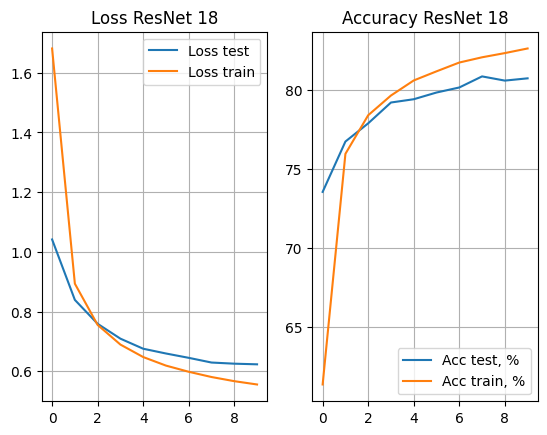

In [14]:
resnet18 = train(model_resnet18, Train, Test, optimizer_resnet18, 'ResNet 18', verbose=True)

In [15]:
model_VGG16 = tv.models.vgg16(weights=tv.models.VGG16_Weights.IMAGENET1K_V1)

for param in model_VGG16.parameters():
    param.requires_grad = False

model_VGG16.classifier[6] = torch.nn.Linear(4096, 47)

print("Params to learn:")
params_to_update = []
for name, param in model_VGG16.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer_VGG16 = torch.optim.Adam(params_to_update, lr=Lr)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [16]:
summary(model_VGG16.to(device), input_size=next(iter(Train))[0][0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [17]:
VGG16 = train(model_VGG16, Train, Test, optimizer_VGG16, 'VGG 16', verbose=True)

Выполнена эпоха - 0  Результаты: 
 Loss -- 1.744736848520049/1.172340906021443, Acc -- 52.86702127659575/69.27659574468085


KeyboardInterrupt: 

In [ ]:
transoforms_inseption = tv.transforms.Compose([tv.transforms.Grayscale(3), tv.transforms.Resize((299, 299)), tv.transforms.ToTensor()])

Data_train_inseption = tv.datasets.EMNIST('.', split='balanced', train=True, download=True, transform=transoforms_inseption)
Data_test_inseption = tv.datasets.EMNIST('.', split='balanced', train=False, download=True, transform=transoforms_inseption)

Train_inseption = torch.utils.data.DataLoader(Data_train_inseption, batch_size=Batch_size, shuffle=True)
Test_inseption = torch.utils.data.DataLoader(Data_test_inseption, batch_size=Batch_size)

model_inception_v3 = tv.models.inception_v3(weights=tv.models.inception.Inception_V3_Weights.IMAGENET1K_V1)

for param in model_inception_v3.parameters():
    param.requires_grad = False

model_inception_v3.fc = torch.nn.Linear(2048, 47)

print("Params to learn:")
params_to_update = []
for name, param in model_inception_v3.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer_inception_v3 = torch.optim.Adam(params_to_update, lr=Lr)

In [ ]:
summary(model_inception_v3.to(device), input_size=next(iter(Train_inseption))[0][0].shape)

In [ ]:
inception_v3 = train(model_inception_v3, Train_inseption, Test_inseption, optimizer_inception_v3, 'Inception v3', verbose=True)

In [ ]:
model_Densenet_161 = tv.models.densenet.densenet161(weights=tv.models.densenet.DenseNet161_Weights.IMAGENET1K_V1)

for param in model_Densenet_161.parameters():
    param.requires_grad = False

model_Densenet_161.classifier = torch.nn.Linear(2208, 47)

print("Params to learn:")
params_to_update = []
for name, param in model_Densenet_161.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer_Densenet_161 = torch.optim.Adam(params_to_update, lr=Lr)

In [ ]:
Densenet_161 = train(model_Densenet_161, Train, Test, optimizer_Densenet_161, 'DenseNet 161', verbose=True)

In [ ]:
resnet18